In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import vonmises

In [3]:
%matplotlib inline

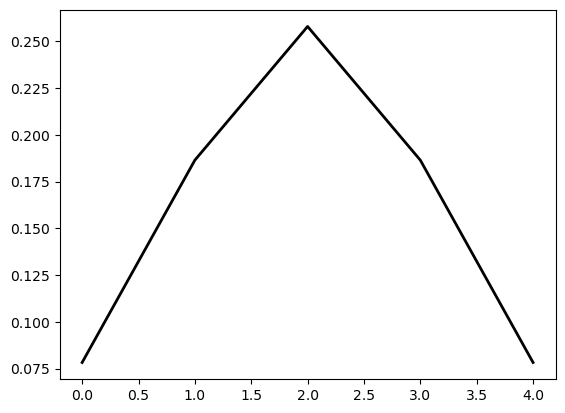

In [4]:
%matplotlib inline
kappa = 2
plt.figure()
rv = vonmises(kappa, loc=0, scale=2.)
x = np.linspace(vonmises.ppf(0.01, kappa),
                vonmises.ppf(0.99, kappa), 9)
plt.plot(np.arange(x.size//2 +1), rv.pdf(x[::2]), 'k-', lw=2, label='frozen pdf')
plt.show()

# Helper functions

In [5]:
def make_bump(size, center, vm_params=(2.,2.)):
    assert(center < size)
    bump = np.zeros(size)
    bump[center] = 1
    return bump

In [6]:
def relu(X):
    return np.maximum(0, X)

In [7]:
from scipy.special import softmax

# Network initialization

In [8]:
n_spatial = 11
n_barcode = 301 # Must be >= n_spatial
n_cache = 3 # Three types

In [9]:
N = n_spatial + n_barcode + n_cache

In [10]:
J = np.zeros((N, N)) # (s,b,c) ordering
s_start = 0
s_end = n_spatial
b_start = s_end
b_end = b_start + n_barcode
c_start = b_end
c_end = -1
SEED = c_start
WATER = c_start + 1
WORM = c_start + 2

In [11]:
# W_sb = W_bs.T as sparse connections
space_to_bar = {}
for i in range(n_spatial): # space to barcode
    bs = np.random.binomial(n=1, p=0.01, size=n_barcode)
    bs = np.argwhere(bs)[:,0]
    space_to_bar[i] = bs
    J[b_start+bs, s_start+i] = 0.5
J[s_start:s_end, b_start:b_end] = J[b_start:b_end, s_start:s_end].T

# Task-defined connections

In [12]:
# Many-to-one connections from barcode to cache type (W_bc)
seed_locs = [2, 5]
curr_loc = [3]
val = 1.
for l in seed_locs:
    bs = b_start + space_to_bar[l]
    J[bs, SEED] = val
    J[SEED, bs] = val

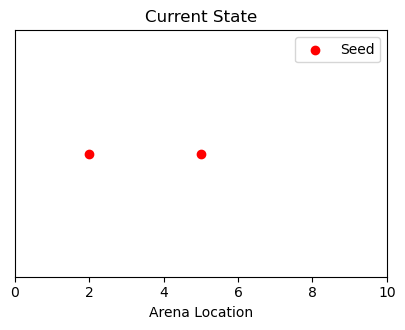

In [13]:
plt.figure(figsize=(4.8, 6.4*0.5))
plt.scatter(
    seed_locs, [1]*len(seed_locs), color='red',
    label='Seed')
plt.legend()
plt.xlim(0, n_spatial-1)
plt.ylim(0, 2)
plt.yticks([])
plt.xlabel('Arena Location')
plt.title('Current State')
plt.show()

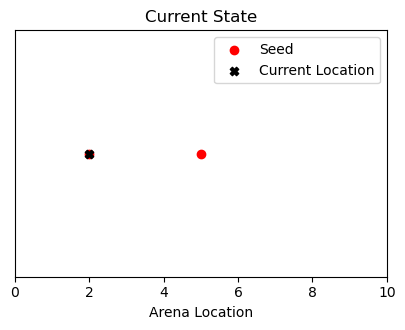

In [14]:
plt.figure(figsize=(4.8, 6.4*0.5))
plt.scatter(
    seed_locs, [1]*len(seed_locs), color='red',
    label='Seed')
plt.scatter(
    [curr_loc[0]-1], [1], color='black',
    marker='X', label='Current Location')
plt.legend()
plt.xlim(0, n_spatial-1)
plt.ylim(0, 2)
plt.yticks([])
plt.xlabel('Arena Location')
plt.title('Current State')
plt.show()

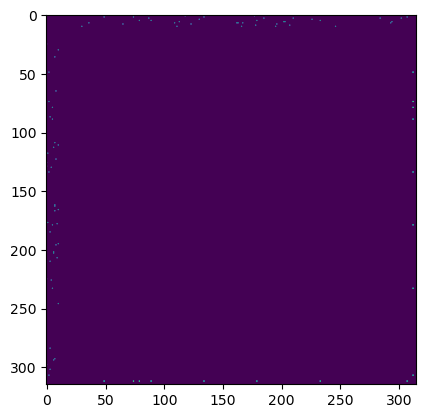

In [15]:
plt.figure()
plt.imshow(J)

# Dynamics Function

In [16]:
def get_activity(
    T, i, softmax_temp=3):
    
    x = x_prev = np.zeros(N)
    x_prev = i
    activities = []
    for t in range(T):
        x = J@(0.9*x_prev) + i
        x[b_start:b_end] = softmax(x[b_start:b_end]*softmax_temp)
        x[b_start:b_end] -= 1.2/n_barcode
        x = relu(x)
        x_prev = x
        activities.append(np.copy(x))
    return activities

# Capacity Plots

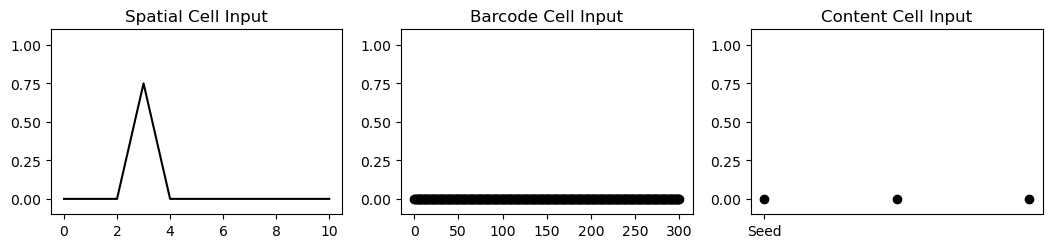

In [17]:
i = np.zeros(N)
i[s_start:s_end] = make_bump(n_spatial, 3, vm_params=(5,0.85))*0.02
i[s_start:s_end] = make_bump(n_spatial, 3, vm_params=None)*0.75
i[b_start:b_end] = 0.

fig, axs = plt.subplots(1, 3, figsize=(6.4*2, 4.8*0.5))
axs[0].plot(i[s_start:s_end], color='k')
axs[1].scatter(np.arange(n_barcode), i[b_start:b_end], color='k')
axs[2].scatter(np.arange(n_cache), i[c_start:], color='k')
axs[0].set_title('Spatial Cell Input')
axs[1].set_title('Barcode Cell Input')
axs[2].set_title('Content Cell Input')
axs[2].set_xticks([0], ['Seed'])
for ax in axs:
    ax.set_ylim(-.1, 1.1)
plt.show()

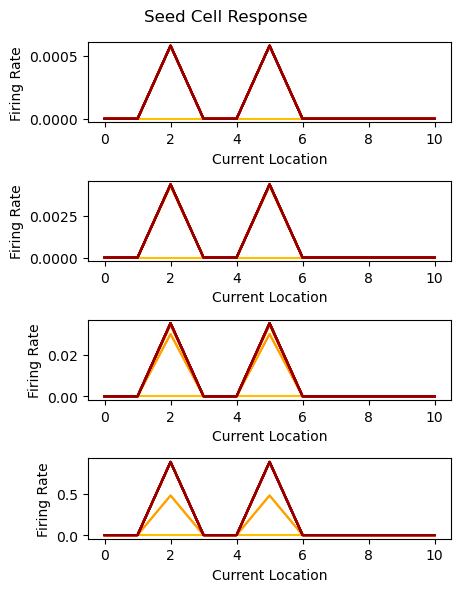

In [18]:
T = 20
noise_std = 0.
temps = [0.5, 1, 3, 10]
fig, axs = plt.subplots(4, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    T_lines = [[] for _ in range(T)]
    for loc in np.arange(n_spatial):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, loc)
        noisy_i = i + np.random.normal(0, 0., size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        for t in range(T):
            x = activities[t]
            T_lines[t].append(x[SEED])
    color = plt.cm.hot_r(np.linspace(0.35, 0.8, T))
    for t in range(T):
        line = T_lines[t]
        axs[temp_idx].plot(line, label=t, color=color[t])
        axs[temp_idx].set_ylabel('Firing Rate')
        axs[temp_idx].set_xlabel('Current Location')
plt.suptitle('Seed Cell Response')
plt.tight_layout()
plt.show()

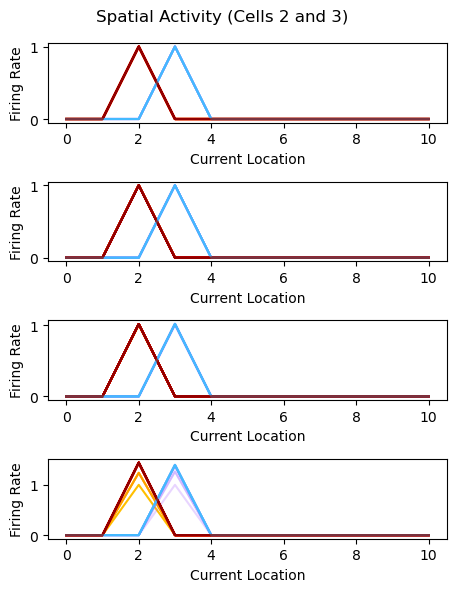

In [19]:
T = 20
noise_std = 0.
temps = [0.5, 1, 3, 10]
fig, axs = plt.subplots(4, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    T_lines = [[] for _ in range(T)]
    T_lines3 = [[] for _ in range(T)]
    for loc in np.arange(n_spatial):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, loc)
        noisy_i = i + np.random.normal(0, 0., size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        for t in range(T):
            x = activities[t]
            T_lines[t].append(x[s_start+2])
            T_lines3[t].append(x[s_start+3])
    color = plt.cm.hot_r(np.linspace(0.35, 0.8, T))
    color3 = plt.cm.cool_r(np.linspace(0.35, 0.8, T))
    for t in range(T):
        line = T_lines[t]
        axs[temp_idx].plot(line, label=t, color=color[t])
        line3 = T_lines3[t]
        axs[temp_idx].plot(line3, label=t, color=color3[t], alpha=0.25)
        #axs[temp_idx].set_yticks([])
        axs[temp_idx].set_ylabel('Firing Rate')
        axs[temp_idx].set_xlabel('Current Location')
plt.suptitle('Spatial Activity (Cells 2 and 3)')
plt.tight_layout()
plt.show()

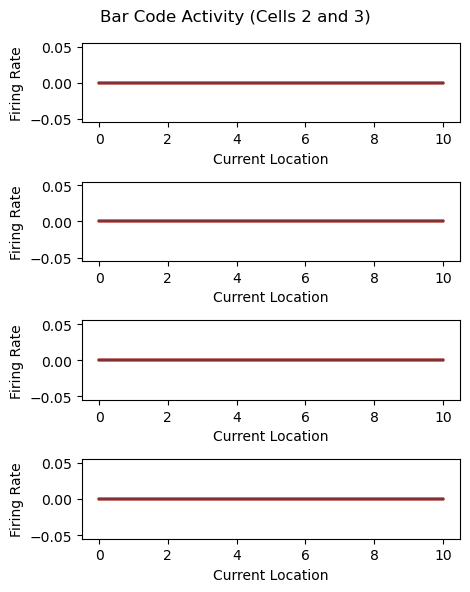

In [20]:
T = 20
noise_std = 0.
temps = [0.5, 1, 3, 10]
fig, axs = plt.subplots(4, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    T_lines = [[] for _ in range(T)]
    T_lines3 = [[] for _ in range(T)]
    for loc in np.arange(n_spatial):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, loc)
        noisy_i = i + np.random.normal(0, 0., size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        for t in range(T):
            x = activities[t]
            T_lines[t].append(x[b_start+2])
            T_lines3[t].append(x[b_start+3])
    color = plt.cm.hot_r(np.linspace(0.35, 0.8, T))
    color3 = plt.cm.cool_r(np.linspace(0.35, 0.8, T))
    for t in range(T):
        line = T_lines[t]
        axs[temp_idx].plot(line, label=t, color=color[t])
        line3 = T_lines3[t]
        axs[temp_idx].plot(line3, label=t, color=color3[t], alpha=0.25)
        #axs[temp_idx].set_yticks([])
        axs[temp_idx].set_ylabel('Firing Rate')
        axs[temp_idx].set_xlabel('Current Location')
plt.suptitle('Bar Code Activity (Cells 2 and 3)')
plt.tight_layout()
plt.show()

# Memory Plots

### Inputs

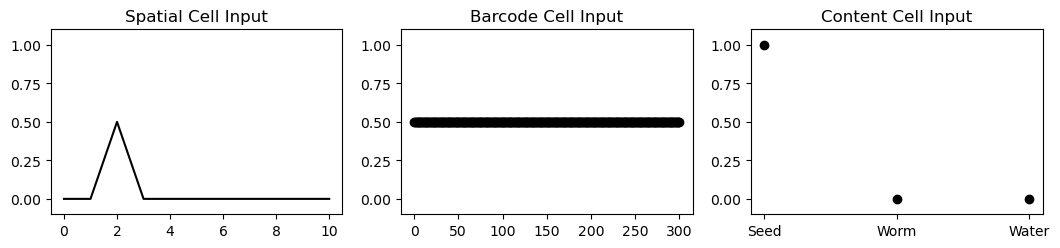

In [21]:
# Given current location and seed type, what's the spatial gradient?
i = np.zeros(N)
i[s_start:s_end] = make_bump(n_spatial, 2, vm_params=None)*0.5
i[b_start:b_end] = 0.5
i[SEED] = 1
fig, axs = plt.subplots(1, 3, figsize=(6.4*2, 4.8*0.5))
axs[0].plot(i[s_start:s_end], color='k')
axs[1].scatter(np.arange(n_barcode), i[b_start:b_end], color='k')
axs[2].scatter(np.arange(n_cache), i[c_start:], color='k')
axs[0].set_title('Spatial Cell Input')
axs[1].set_title('Barcode Cell Input')
axs[2].set_title('Content Cell Input')
axs[2].set_xticks([0,1,2], ['Seed', 'Worm', 'Water'])
for ax in axs:
    ax.set_ylim(-.1, 1.1)
plt.show()

In [22]:
from scipy.stats import sem

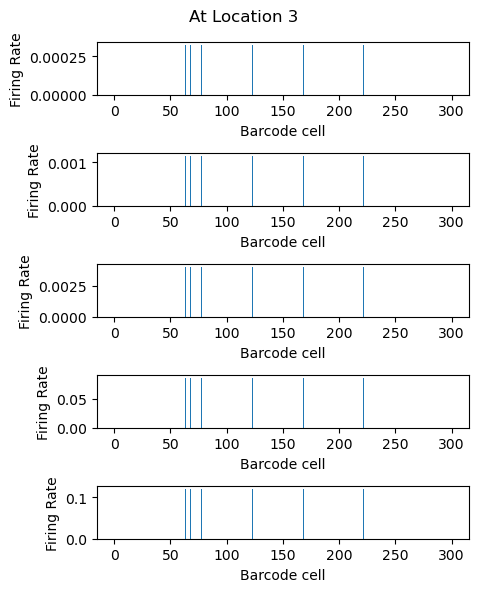

In [23]:
T = 20
plot_t = 19
iters = 40
noise_std = 0.
temps = [0.3, 0.5, 1, 3, 10]
fig, axs = plt.subplots(5, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    X = []
    for _ in range(iters):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, 3, vm_params=None)*0.5
        i[b_start:b_end] = 0.5
        i[SEED] = 1
        noisy_i = i + np.random.normal(0, noise_std, size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        x = activities[plot_t]
        X.append(x[b_start:b_end])
    X = np.array(X).T
    means = np.mean(X, axis=1)
    sems = sem(X, axis=1)
    axs[temp_idx].bar(np.arange(n_barcode), means, xerr=sems)
    axs[temp_idx].set_xlabel('Barcode cell')
    axs[temp_idx].set_ylabel('Firing Rate')
#     axs[temp_idx].set_yticks([])
plt.suptitle('At Location 3')
plt.tight_layout()
plt.show()

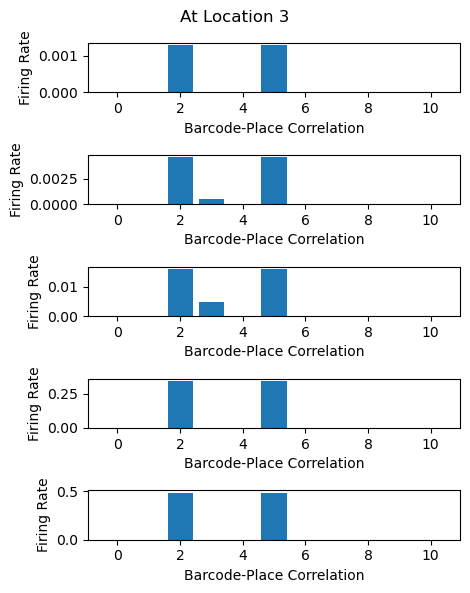

In [24]:
T = 20
plot_t = 19
iters = 40
noise_std = 0.
temps = [0.3, 0.5, 1, 3, 10]
fig, axs = plt.subplots(5, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    X = []
    for _ in range(iters):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, 3, vm_params=None)#*0.5
        i[b_start:b_end] = 0.5
        i[SEED] = 1
        noisy_i = i + np.random.normal(0, noise_std, size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        x = activities[plot_t]
        corrs = []
        for l in np.arange(n_spatial):
            barcode = np.zeros(n_barcode)
            barcode[space_to_bar[l]] = 1
            corr = np.dot(x[b_start:b_end], barcode)
            corrs.append(corr)
        X.append(corrs)
    X = np.array(X).T
    means = np.mean(X, axis=1)
    sems = sem(X, axis=1)
    axs[temp_idx].bar(np.arange(n_spatial), means, xerr=sems)
    axs[temp_idx].set_xlabel('Barcode-Place Correlation')
    axs[temp_idx].set_ylabel('Firing Rate')
#     axs[temp_idx].set_yticks([])
plt.suptitle('At Location 3')
plt.tight_layout()
plt.show()

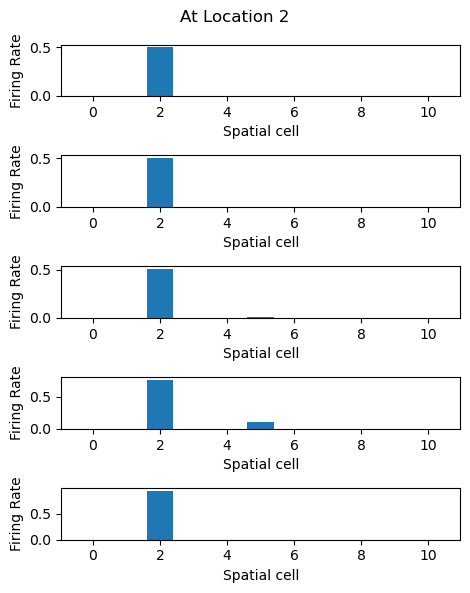

In [25]:
T = 20
plot_t = 19
iters = 40
noise_std = 0.
temps = [0.3, 0.5, 1, 3, 10]
fig, axs = plt.subplots(5, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    X = []
    for _ in range(iters):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, 2, vm_params=None)*0.5
        i[b_start:b_end] = 0.5
        i[SEED] = 1
        noisy_i = i + np.random.normal(0, noise_std, size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        x = activities[plot_t]
        X.append(x[s_start:s_end])
        #X.append(x[b_start:b_end])
    X = np.array(X).T
    means = np.mean(X, axis=1)
    sems = sem(X, axis=1)
    axs[temp_idx].bar(np.arange(n_spatial), means, xerr=sems)
    axs[temp_idx].set_xlabel('Spatial cell')
    axs[temp_idx].set_ylabel('Firing Rate')
    #axs[temp_idx].set_yticks([])
plt.suptitle('At Location 2')
plt.tight_layout()
plt.show()

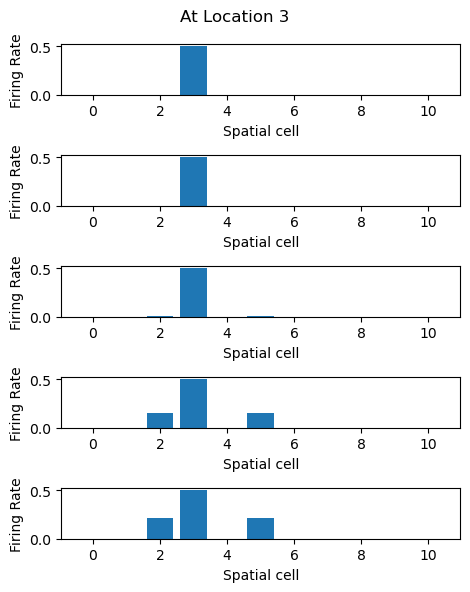

In [26]:
T = 20
plot_t = 19
iters = 40
noise_std = 0.
temps = [0.3, 0.5, 1, 3, 10]
fig, axs = plt.subplots(5, 1, figsize=(6.4*0.75, 4.8*1.25))

for temp_idx, temp in enumerate(temps):
    X = []
    for _ in range(iters):
        i = np.zeros(N)
        i[s_start:s_end] = make_bump(n_spatial, 3, vm_params=None)*0.5
        i[b_start:b_end] = 0.5
        i[SEED] = 1
        noisy_i = i + np.random.normal(0, noise_std, size=i.size)
        activities = get_activity(T, noisy_i, softmax_temp=temp)
        x = activities[plot_t]
        X.append(x[s_start:s_end])
        #X.append(x[b_start:b_end])
    X = np.array(X).T
    means = np.mean(X, axis=1)
    sems = sem(X, axis=1)
    axs[temp_idx].bar(np.arange(n_spatial), means, xerr=sems)
    axs[temp_idx].set_xlabel('Spatial cell')
    axs[temp_idx].set_ylabel('Firing Rate')
    #axs[temp_idx].set_yticks([])
plt.suptitle('At Location 3')
plt.tight_layout()
plt.show()